### Group 7: Sama - Negin - Sara - Shayesteh - Leila - Maryam / Assignment 5- 12 Dec 2024

## I. Regression Modeling

In [62]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

from astsadata import *


In [63]:
def ccf(x, y, max_lag, ccf_type='correlation', ax=None, return_values=False, **kwargs):
    """
    Calculate and optionally plot the cross-correlation or cross-covariance function.

    Parameters:
    - x, y: Input time series.
    - max_lag: Maximum lag to compute.
    - ccf_type: 'correlation' for cross-correlation, 'covariance' for cross-covariance.
    - ax: Matplotlib axis to plot on. If None, a new axis is created.
    - return_values: If True, the function will return the CCF/CCoV values and lags.
    - **kwargs: Additional keyword arguments for the plot.

    Returns:
    - If return_values is True, returns (lags, ccf).
    """
    #import statsmodels.api as sm

    lags = np.arange(-max_lag, max_lag + 1)

    if ccf_type == 'correlation':
        backwards = sm.tsa.ccf(x[::-1], y[::-1], adjusted=False)[max_lag::-1]
        forwards = sm.tsa.ccf(x, y, adjusted=False)[:max_lag + 1]
        ccf = np.r_[backwards[:-1], forwards]
        ylabel = 'CCF'
    elif ccf_type == 'covariance':
        backwards = sm.tsa.ccovf(x[::-1], y[::-1], adjusted=False)[max_lag::-1]
        forwards = sm.tsa.ccovf(x, y, adjusted=False)[:max_lag + 1]
        ccf = np.r_[backwards[:-1], forwards]
        ylabel = 'CCoV'

    if return_values:
        return lags, ccf

    if ax is None:
        ax = plt.gca()

    ax.bar(lags, ccf, **kwargs)
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    if ccf_type == 'correlation':
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color='red', linestyle='--', linewidth=1)
        ax.axhline(-conf_level, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('LAG')
    ax.set_ylabel(ylabel)

    return ax


In [64]:
# Read the dataset

X = pd.read_csv('multiTimeline2.csv', index_col = 0, parse_dates = True)
X.head()


,fiets,strand,handschoenen,Snowboard
Month,,,,
2004-01-01,25,11,1,14
2004-02-01,27,11,1,11
2004-03-01,35,13,1,7
2004-04-01,41,15,1,3
2004-05-01,44,16,1,2


-----
### Dataset: Derived from Google Trends, Location: The Netherlands
We used Dutch keywords to tailor our data to the local population. Below are the meanings of each keyword:

fiets → Bicycle

strand → Beach

temperatuur → Temperature

handschoenen → Gloves


### Out Target is to create a model for predicting the "fiets".


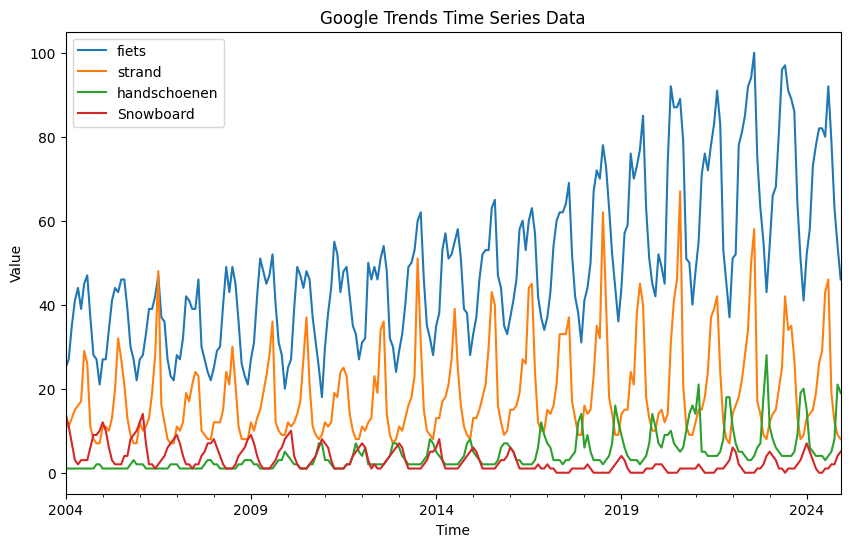

In [66]:
# Define time series

fiet_ts = pd.Series(X.values[:,0], index = X.index)
str_ts = pd.Series(X.values[:,1], index = X.index)
hnd_ts = pd.Series(X.values[:,2], index = X.index)
snb_ts = pd.Series(X.values[:,3], index = X.index)

xcol = ['fiets', 'strand', 'handschoenen', 'Snowboard']

# Plot time series
plt.figure(figsize=(10, 6))

fiet_ts.plot()
str_ts.plot()
hnd_ts.plot()
snb_ts. plot()


plt.title('Google Trends Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(xcol, loc = 'upper left') 

plt.show()


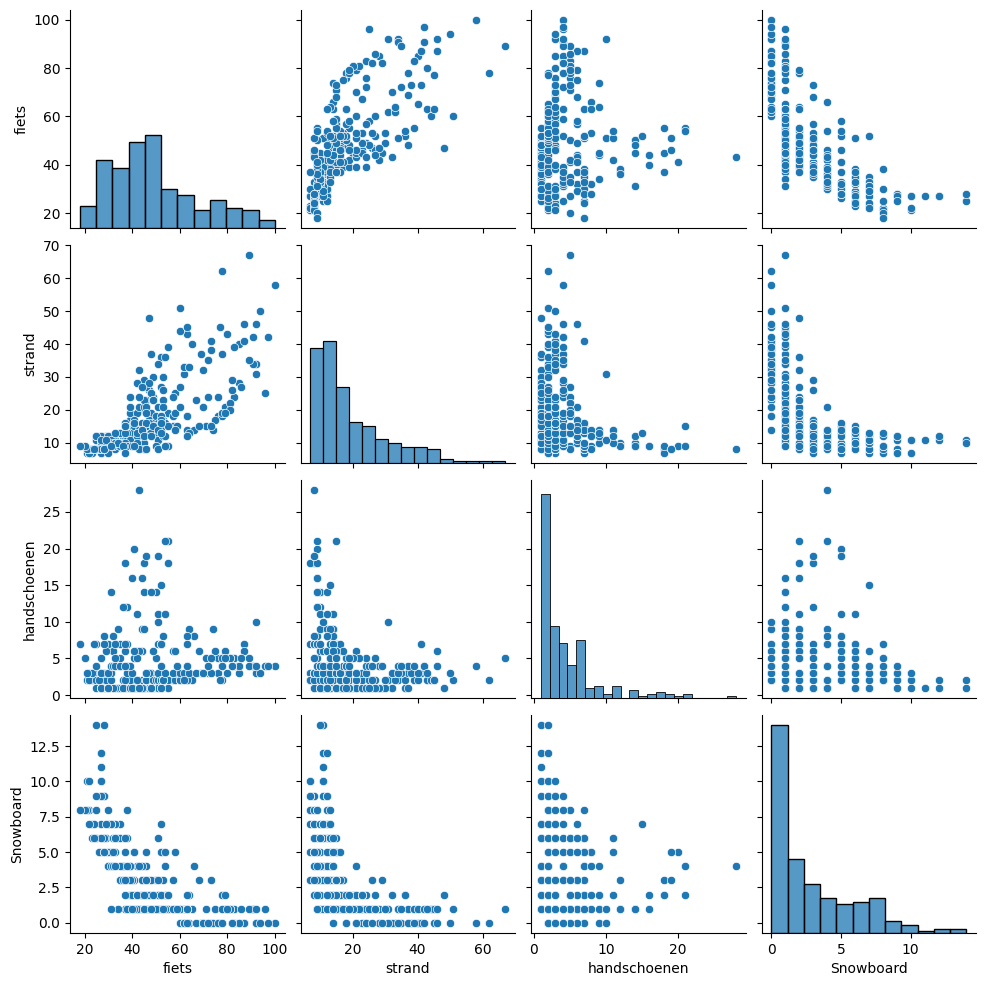

In [67]:
# Scatter plots

sns.pairplot(X)

plt.show()


-----

### First Model
For the first model, according to the plots we assume there is a good correlation between fiets and strand.

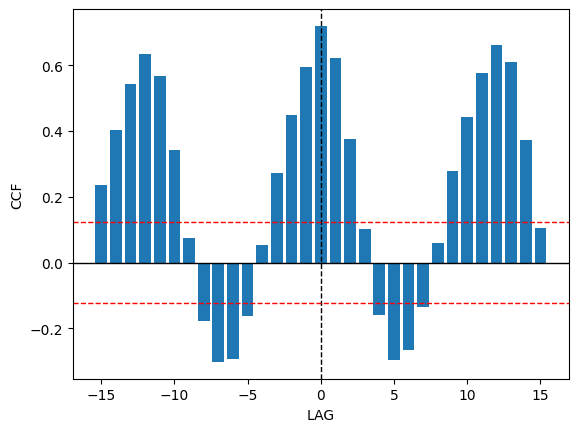

In [68]:
ccf(fiet_ts, str_ts, max_lag = 15)
plt.show()

In [69]:
# Regression modeling

model_1= ols(formula = 'fiets ~ strand', data = X).fit()

print(model_1.summary())


                            OLS Regression Results                            
Dep. Variable:                  fiets   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     267.9
Date:                Thu, 12 Dec 2024   Prob (F-statistic):           2.03e-41
Time:                        18:41:41   Log-Likelihood:                -1000.7
No. Observations:                 252   AIC:                             2005.
Df Residuals:                     250   BIC:                             2012.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.0687      1.575     17.187      0.0

-----

To improve our prediction we would like to add more features, let's investigate cross correlation between other parameters in different lags. 

We see good improvement in R-squared from 0.520 to 0.762. There is still room for improvement, so maybe we can try other features.

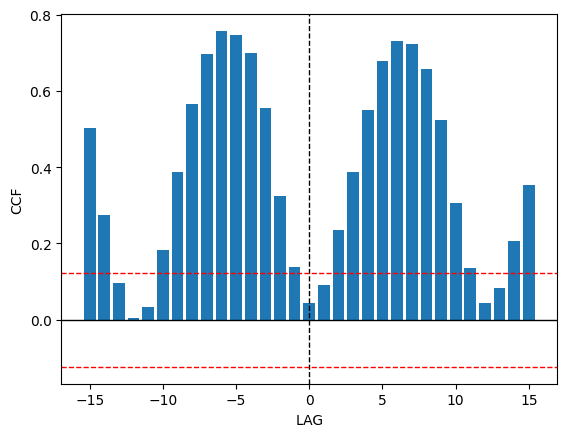

In [70]:
# Cross-correlation between fiets and handschoenen

ccf(fiet_ts, hnd_ts, max_lag = 15)
plt.show()


By shifting handschoenen to 6 lag later, we can get a better results.

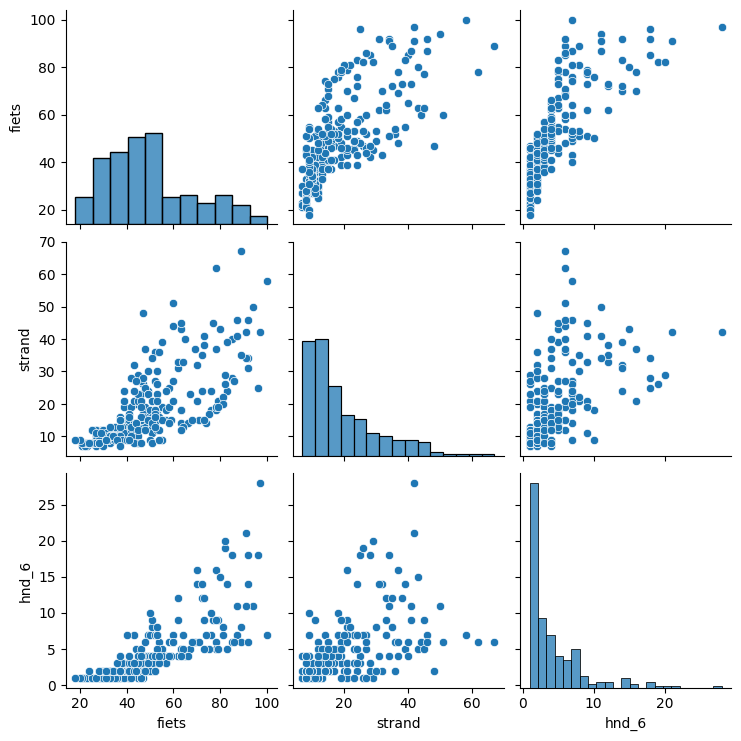

In [71]:
# Scatter plots


hnd_6_ts = hnd_ts.shift(6)
X3 = pd.DataFrame({'fiets': fiet_ts, 'strand': str_ts, 'hnd_6': hnd_6_ts}).dropna()

sns.pairplot(X3)

plt.show()


In [ ]:
# Model 2

model_3 = ols(formula = 'fiets ~ strand + hnd_6', data = X3).fit()

print(model_3.summary())


                            OLS Regression Results                            
Dep. Variable:                  fiets   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     324.2
Date:                Thu, 12 Dec 2024   Prob (F-statistic):           2.61e-69
Time:                        18:43:18   Log-Likelihood:                -907.37
No. Observations:                 246   AIC:                             1821.
Df Residuals:                     243   BIC:                             1831.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.1242      1.206     21.667      0.0

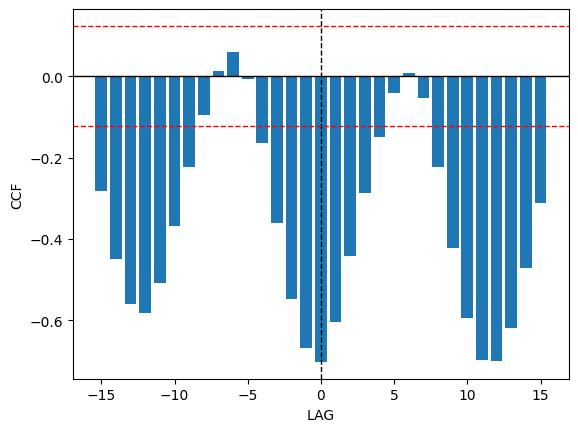

In [73]:
ccf(fiet_ts, snb_ts, max_lag = 15)
plt.show()

In [ ]:
snb_0_ts = hnd_ts.shift(0)
snb_12_ts = hnd_ts.shift(12)
X4 = pd.DataFrame({'fiets': fiet_ts, 'strand': str_ts, 'hnd_6': hnd_6_ts, 'snb_0':snb_0_ts, 'snb_12':snb_12_ts}).dropna()
model_4 = ols(formula = 'fiets ~ strand + hnd_6', data = X4).fit()

print(model_4.summary())


                            OLS Regression Results                            
Dep. Variable:                  fiets   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     310.4
Date:                Thu, 12 Dec 2024   Prob (F-statistic):           6.27e-67
Time:                        18:58:18   Log-Likelihood:                -886.93
No. Observations:                 240   AIC:                             1780.
Df Residuals:                     237   BIC:                             1790.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.3935      1.233     21.409      0.0

: 

We see improvement in out model and now we have a great R-squared : 0.847. Of course by adding more relevant features it is possible to get a better results in the future.
Let's see how our model works.

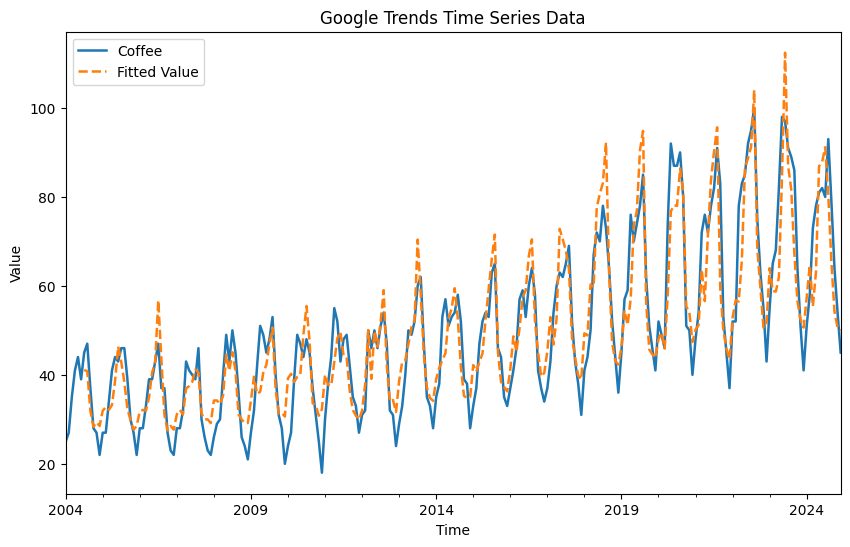

In [20]:
# Plot the time series data and the fitted values on the training set

fiet2_ts = pd.Series(model_3.fittedvalues.values, index=X.index[6:])

plt.figure(figsize = (10, 6))

fiet_ts.plot(linewidth = 1.8)
fiet2_ts.plot(linestyle = '--', linewidth = 1.8)

plt.title('Google Trends Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Coffee', 'Fitted Value'], loc = 'upper left') 

plt.show()
